# Updating priors

In this notebook, I will show how it is possible to update the priors as new data becomes available. The example is a slightly modified version of the linear regression in the [Getting started with PyMC3](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/getting_started.ipynb) notebook.

In [1]:
%matplotlib inline
import warnings

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from pymc3 import Model, Normal, Slice, sample
from pymc3.distributions import Interpolated
from scipy import stats
from theano import as_op

plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:
warnings.filterwarnings("ignore")

## Generating data

In [3]:
# Initialize random number generator
np.random.seed(93457)

# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

## Model specification

Our initial beliefs about the parameters are quite informative (sigma=1) and a bit off the true values.

In [4]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal("alpha", mu=0, sigma=1)
    beta0 = Normal("beta0", mu=12, sigma=1)
    beta1 = Normal("beta1", mu=18, sigma=1)

    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    # draw 1000 posterior samples
    trace = sample(1000)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '73117' (I am process '73202')
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.


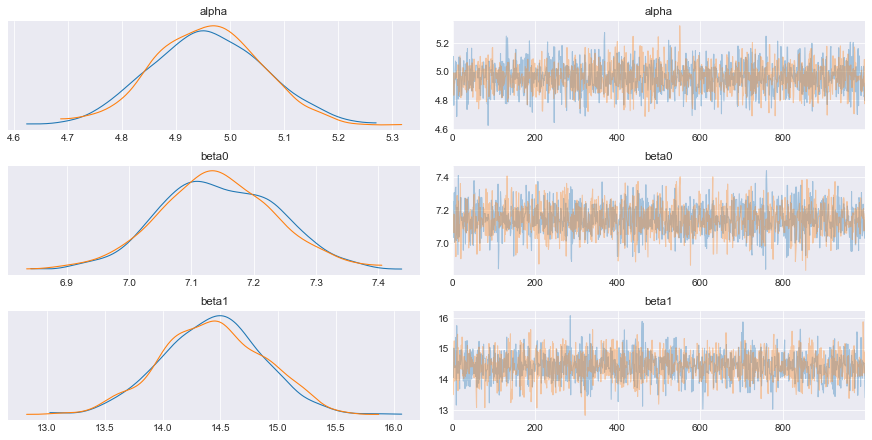

In [5]:
az.plot_trace(trace);

In order to update our beliefs about the parameters, we use the posterior distributions, which will be used as the prior distributions for the next inference. The data used for each inference iteration has to be independent from the previous iterations, otherwise the same (possibly wrong) belief is injected over and over in the system, amplifying the errors and misleading the inference. By ensuring the data is independent, the system should converge to the true parameter values.

Because we draw samples from the posterior distribution (shown on the right in the figure above), we need to estimate their probability density (shown on the left in the figure above). [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) is a way to achieve this, and we will use this technique here. In any case, it is an empirical distribution that cannot be expressed analytically. Fortunately PyMC3 provides a way to use custom distributions, via `Interpolated` class.

In [6]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

Now we just need to generate more data and build our Bayesian model so that the prior distributions for the current iteration are the posterior distributions from the previous iteration. It is still possible to continue using NUTS sampling method because `Interpolated` class implements calculation of gradients that are necessary for Hamiltonian Monte Carlo samplers.

In [7]:
traces = [trace]

In [8]:
for _ in range(10):
    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior("alpha", trace["alpha"])
        beta0 = from_posterior("beta0", trace["beta0"])
        beta1 = from_posterior("beta1", trace["beta1"])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 31 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
The acceptance probability does not match the target. It is 0.6234985584825807, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.


Posterior distributions after 11 iterations.


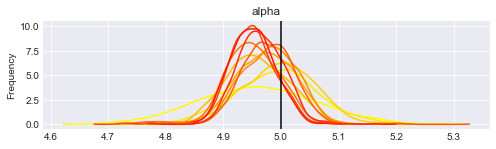

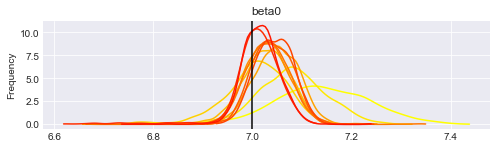

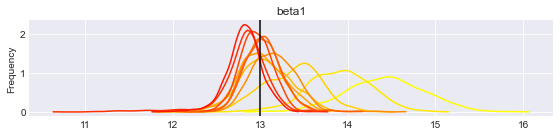

In [9]:
print("Posterior distributions after " + str(len(traces)) + " iterations.")
cmap = mpl.cm.autumn
for param in ["alpha", "beta0", "beta1"]:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({"alpha": alpha_true, "beta0": beta0_true, "beta1": beta1_true}[param], c="k")
    plt.ylabel("Frequency")
    plt.title(param)

plt.tight_layout();

You can re-execute the last two cells to generate more updates.

What is interesting to note is that the posterior distributions for our parameters tend to get centered on their true value (vertical lines), and the distribution gets thiner and thiner. This means that we get more confident each time, and the (false) belief we had at the beginning gets flushed away by the new data we incorporate.

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Jan 17 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

matplotlib: 3.3.3
arviz     : 0.10.0
numpy     : 1.19.2
pymc3     : 3.10.0
scipy     : 1.6.0
theano    : 1.0.14

Watermark: 2.1.0

